In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy import stats

from sqlalchemy import text, create_engine

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import env
import acquire as a
import prepare as p
import wrangle as w
import explore as exp
import evaluate as eva
import pretty as muah
import knear as k

import warnings
warnings.filterwarnings("ignore")

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host_name}/logs'
engine = create_engine(url)    
df = pd.read_sql(text('SELECT * FROM api_access'), engine.connect())
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# create synthetic records and append them to the dataframe
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])


In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
# check out count and frequency
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [6]:
# check out frequency percentage
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

In [7]:
# create a function that combines value counts and frequencies
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
# check it out
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


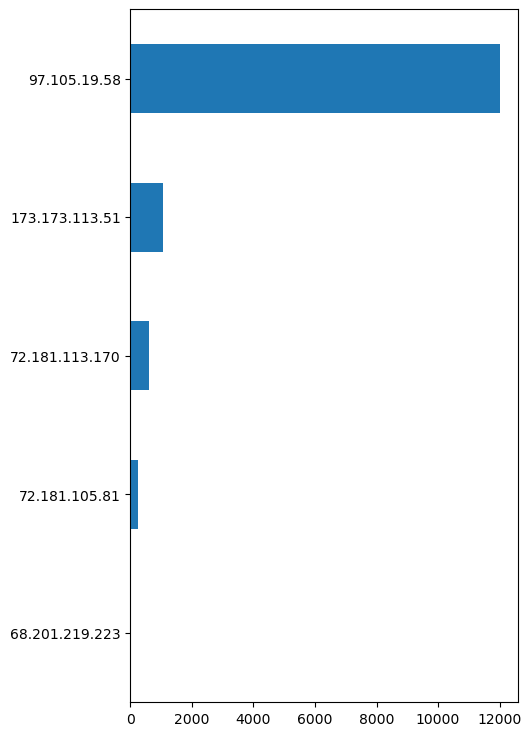

In [9]:
# visualize individual instances of ip addresses
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

In [10]:
# all ip addresses have seen status code 200
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [11]:
# what about other than 200?
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [12]:
# investigate the two that have only 301 as a status code
df[df.ip == '97.105.15.120']


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [13]:
df[df.ip == '95.31.16.121']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [14]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [15]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [17]:
df.dtypes

ip                 object
request_method     object
request_path       object
http_version       object
status_code        object
size                int64
user_agent         object
size_mb           float64
dtype: object

In [18]:
# size
size_mb_df = value_counts_and_frequencies(df.size_mb)
size_mb_df.head()

,count,proba
0.471896,705,0.050436
0.003396,548,0.039204
0.003489,291,0.020818
0.001266,229,0.016383
0.001704,219,0.015667


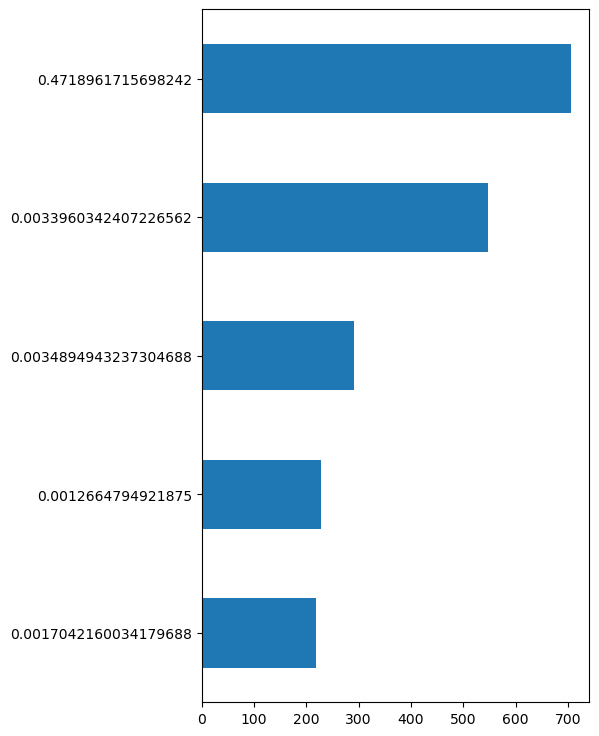

In [19]:
# visualize individual instances of size_mb
size_mb_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

In [21]:
# all ip addresses have seen status code 200
status_given_size_mb = (
    df.groupby('size_mb')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_size_mb.head()

,size_mb,status_code,proba_status_given_ip
0,0.000000,499,1.0
1,0.000040,200,1.0
2,0.000046,200,1.0
3,0.000120,200,1.0
4,0.000154,200,1.0


In [22]:
# what about other than 200?
status_given_size_mb[status_given_size_mb.status_code != '200']

,size_mb,status_code,proba_status_given_ip
0,0.000000,499,1.0
6,0.000958,301,1.0
9,0.002441,301,1.0


In [23]:
# investigate the two that have only 301 as a status code
df[df.ip == '0.000000']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,


In [24]:
# size
size_df = value_counts_and_frequencies(df['size'])
size_df.head()

,count,proba
494819,705,0.050436
3561,548,0.039204
3659,291,0.020818
1328,229,0.016383
1787,219,0.015667


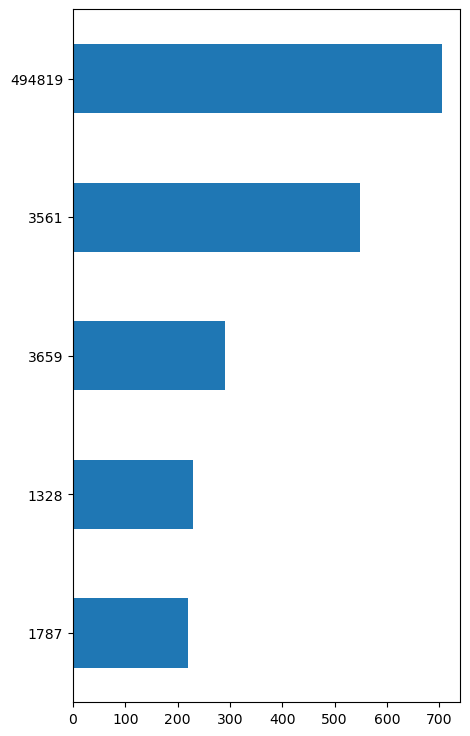

In [25]:
# visualize individual instances of size
size_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()

In [29]:
# all ip addresses 
status_given_size_mb = (
    df.groupby('ip')
    ['size'].value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_size_mb

,ip,size,proba_status_given_ip
0,173.173.113.51,3561,0.060434
1,173.173.113.51,1787,0.058546
2,173.173.113.51,3659,0.058546
3,173.173.113.51,1328,0.050992
4,173.173.113.51,510134,0.013220
...,...,...,...
744,97.105.19.58,278377,0.000083
745,97.105.19.58,327529,0.000083
746,97.105.19.58,343913,0.000083
747,97.105.19.58,360297,0.000083


In [28]:
# investigate 
df[df['size'] == 510134]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:37:11,97.105.19.58,GET,/api/v1/sales?page=153,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-16 19:39:37,97.105.19.58,GET,/api/v1/sales?page=75,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-16 19:39:39,97.105.19.58,GET,/api/v1/sales?page=76,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-16 19:41:34,97.105.19.58,GET,/api/v1/sales?page=75,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-16 19:41:36,97.105.19.58,GET,/api/v1/sales?page=76,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
...,...,...,...,...,...,...,...,...
2019-04-17 04:44:35,173.173.113.51,GET,/api/v1/sales?page=75,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-17 04:44:38,173.173.113.51,GET,/api/v1/sales?page=76,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
2019-04-17 05:14:39,173.173.113.51,GET,/api/v1/sales?page=75,HTTP/1.1,200,510134,python-requests/2.21.0,0.486502
